In [1]:
using COVIDResourceAllocation: forecast, n_beds

In [34]:
using DataFrames
using Dates
using Gadfly
using Compose

In [10]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI", "VT"]
start_date = Date(2020, 3, 1)
end_date = Date(2020, 6, 1);

In [11]:
forecast_active_ihme = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
);
forecast_active_ihme_lb = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:lb,
);
forecast_active_ihme_ub = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:ub,
);

In [12]:
forecast_active_ihme_total = sum(forecast_active_ihme, dims=1)
forecast_active_ihme_total_lb = sum(forecast_active_ihme_lb, dims=1)
forecast_active_ihme_total_ub = sum(forecast_active_ihme_ub, dims=1);

In [27]:
beds = n_beds(states);
total_beds = sum(beds);

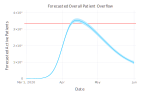

In [28]:
Gadfly.plot(
    x=start_date:Day(1):end_date,
    y=forecast_active_ihme_total,
    ymin=forecast_active_ihme_total_lb,
    ymax=forecast_active_ihme_total_ub,
    Geom.line, Geom.ribbon,
    yintercept=[total_beds], Geom.hline(color="red"),
    Guide.xlabel("Date"), Guide.ylabel("Forecasted Active Patients"),
    Guide.title("Forecasted Overall Patient Overflow"),
) |> SVG()

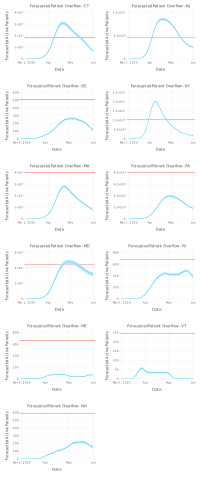

In [42]:
plots = Union{Plot,Compose.Context}[]
for (i,s) in enumerate(states)
    plt = Gadfly.plot(
        x=start_date:Day(1):end_date,
        y=forecast_active_ihme[i,:],
        ymin=forecast_active_ihme_lb[i,:],
        ymax=forecast_active_ihme_ub[i,:],
        Geom.line, Geom.ribbon,
        yintercept=[beds[i]], Geom.hline(color="red"),
        Guide.xlabel("Date"), Guide.ylabel("Forecasted Active Patients"),
        Guide.title("Forecasted Patient Overflow - $(s)"),
    )
    push!(plots, plt)
end
if (length(plots)%2 != 0) push!(plots, Compose.context()) end
gridstack(reshape(plots, (div(length(plots), 2),2))) |> SVG(20cm, length(plots)/2*8cm)